In [1]:
import numpy as np
from matplotlib import pyplot as plt
from SYK_fft import *
from ConformalAnalytical import *
import testingscripts

In [2]:
testingscripts.realtimeFFT_validator() # Should return True

True

In [3]:
def rhotosigma(rhoG,rhoD,M,dt,t,g,kappa=1,delta=1e-6):
    '''
    returns [Sigma,Pi] given rhos
    '''
    rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
    rhoFpp = (1/np.pi)*freq2time(rhoG * fermidirac(beta*omega),M,dt)
    rhoFpm = (1/np.pi)*freq2time(rhoG * fermidirac(-1.*beta*omega),M,dt)
    rhoFmp = (1/np.pi)*freq2time(rhoGrev * fermidirac(beta*(omega)),M,dt)
    rhoFmm = (1/np.pi)*freq2time(rhoGrev * fermidirac(-1.*beta*omega),M,dt)
    rhoBpp = (1/np.pi)*freq2time(rhoD * boseeinstein(beta*(omega+delta)),M,dt)
    rhoBpm = (1/np.pi)*freq2time(rhoD * boseeinstein(-1.*beta*(omega+delta)),M,dt)
    
    argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1.0)
    Sigma = 1j*(g**2)*kappa * time2freq(argSigma,M,dt)
    
    argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1.0)
    Pi = 2*1j*(g**2) * time2freq(argPi,M,dt)
    
    return [Sigma, Pi]

In [4]:
g = 0.5
mu = 0.
r = 1.
eta = 1e-6
beta = 100.

M = int(2**18) #number of points in the grid
T = 2000 #upper cut-off fot the time
dt = (2*T)/((2*M))
t = dt * (np.arange(2*M) - M)

dw = np.pi/(M*dt)
omega = dw * (np.arange(2*M) - M) 
np.testing.assert_almost_equal(dt*dw*M,np.pi,5, "Error in fundamentals")
err = 1e-3

#delta = 0.420374134464041
np.testing.assert_almost_equal(np.max(np.abs(omega)),np.pi*M/T,5,"Error in creating omega grid")

In [5]:
#GRomega = (1j)*np.ones(2*M)
#GRomega = time2freq(GRconf(t+1j*delta,J = Jot,beta = beta),M,dt)
GRomega = 1/(omega + 1j*eta + mu)
#DRomega = 1/(-1.0*(omega+1j*eta)**2 + r)
DRomega = np.ones(2*M)


itern = 0

omegar2 = ret_omegar2(g,beta)

diff = 1 
diffG,diffD = (0.5,0.5)
xG,xD = (0.5,0.5)

while (diff>err and itern<200): 
    itern += 1 
    diffoldG,diffoldD = (diffG,diffD)
    GRoldomega,DRoldomega = (1.0*GRomega, 1.0*DRomega)
    
    rhoG = -1.0*np.imag(GRomega)
    rhoD = -1.0*np.imag(DRomega)
    
    SigmaOmega,PiOmega = rhotosigma(rhoG,rhoD,M,dt,t,g,kappa=1,delta=1e-6)
    
    if itern < 2000 : 
        PiOmega[M] = 1.0*r - omegar2
   
    GRomega = 1.0*xG/(omega + 1j*eta + mu - SigmaOmega) + (1-xG)*GRoldomega
    DRomega = 1.0*xD/(-1.0*(omega+1j*eta)**2 + r - PiOmega) + (1-xD)*DRoldomega
    
    
   
    diffG = np. sqrt((0.5/M) * np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
    diffD = np. sqrt((0.5/M) * np.sum((np.abs(DRomega-DRoldomega))**2))
    diff = np.max([diffG,diffD])
    
    if diffG>diffoldG:
        xG/=2.
    if diffD>diffoldD:
        xD/=2.
    print("itern = ",itern, " , diff = ", diffG, diffD, " , x = ", xG, xD, end = '\r')
        



/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:87: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0 + np.exp(arg)))
/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:102: RuntimeWarning: overflow encountered in exp
  return (1.0/(np.exp(arg)-1))


In [6]:
GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)

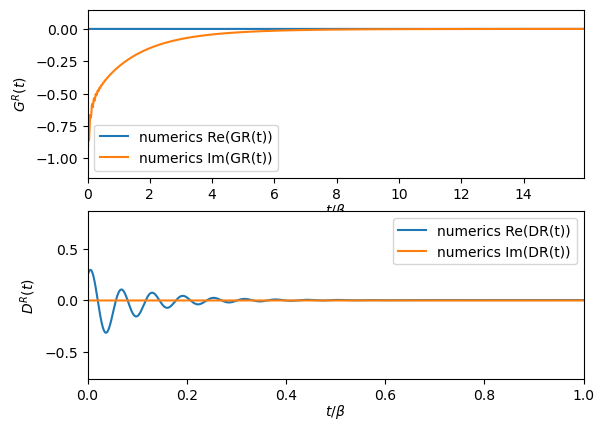

In [7]:
fig, ax = plt.subplots(2)

ax[0].plot(t/beta, np.real(GRt), label = r'numerics Re(GR(t))')
ax[0].plot(t/beta, np.imag(GRt), label = r'numerics Im(GR(t))')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(0,beta/(2*np.pi))
ax[0].set_xlabel(r'$t/\beta$',labelpad = 0)
ax[0].set_ylabel(r'${G^R(t)}$')
ax[0].legend()

ax[1].plot(t/beta, np.real(DRt), label = 'numerics Re(DR(t))')
ax[1].plot(t/beta, np.imag(DRt), label = 'numerics Im(DR(t))')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$t/\beta$',labelpad = 0)
ax[1].set_ylabel(r'${D^R(t)}$')
#ax[1].set_xlim(0,beta/(2*np.pi))
ax[1].set_xlim(0,1)
ax[1].legend()


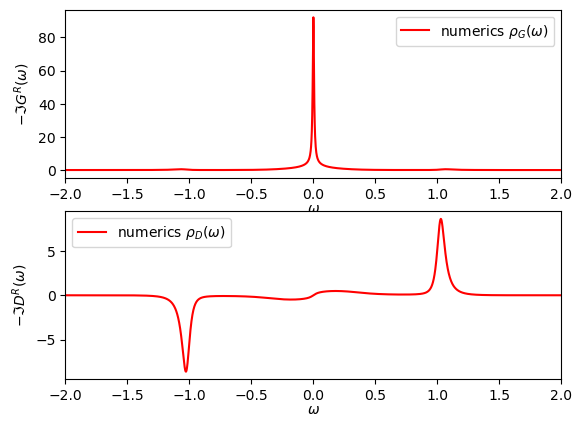

In [8]:
fig, ax = plt.subplots(2)

ax[0].plot(omega, rhoG, 'r', label = r'numerics $\rho_G(\omega)$')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-2,2)
ax[0].set_xlabel(r'$\omega$',labelpad = 0)
ax[0].set_ylabel(r'$-\Im{G^R(\omega)}$')
ax[0].legend()

ax[1].plot(omega, rhoD, 'r', label = r'numerics $\rho_D(\omega)$')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
#ax[1].plot(omega,rhoD*boseeinstein(beta*omega), label = 'density of states')
ax[1].set_xlabel(r'$\omega$',labelpad = 0)
ax[1].set_ylabel(r'$-\Im{D^R(\omega)}$')
ax[1].set_xlim(-2,2)
ax[1].legend()


In [9]:
dw, beta 

(0.0015707963267948967, 100.0)

/var/folders/45/s5_xwz0118sg3syff0jyt5wc0000gn/T/ipykernel_95373/3678154118.py:11: RuntimeWarning: divide by zero encountered in power
  conf_fit_G = 1 * np.abs(omega)**(2*delta - 1)


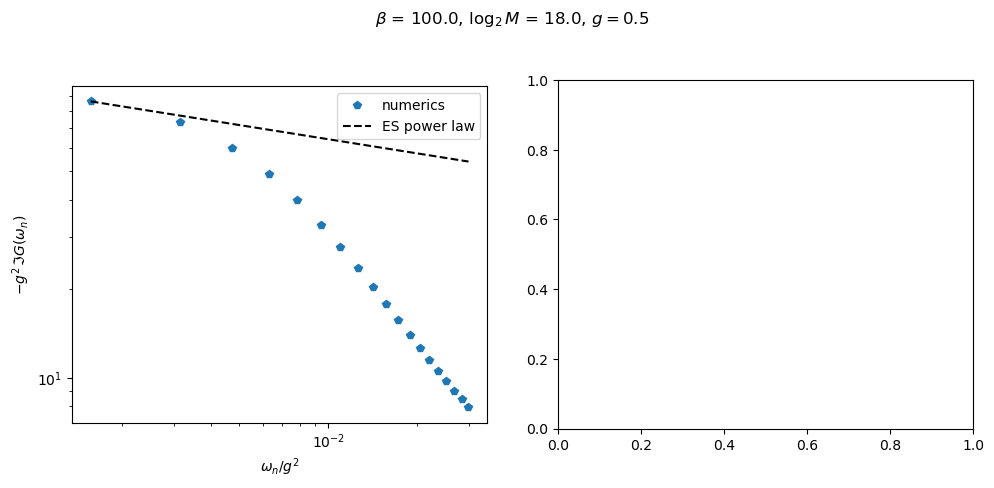

In [10]:
# Delta = 0.42
# powD = 1. - 4*Delta
# plt.loglog(omega[M+1:M+50], np.abs(DRomega[M+1:M+50]),'.') 
# fudfacD = np.abs(DRomega[M+1])/((omega[M+1])**powD)
# plt.loglog(omega[M+1:M+50], fudfacD * (omega[M+1:M+50])**powD)
delta = 0.420374134464041
start,stop = M+1, M+20

fitG_val = -np.imag(GRomega[start])
#fitG_val = -np.imag(Gconf[start])
conf_fit_G = 1 * np.abs(omega)**(2*delta - 1)
conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val
#alt_conf_fit_G = fitG_val * np.abs(omega/(g**2))**(2*alt_delta - 1)

# fitD_val = np.real(Domega[startB])*(g**2)
# #fitD_val = np.real(Dconf[startB])
# conf_fit_D = 1 * np.abs(nu[startB:]/(g**2))**(1-4*delta)
# conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val
# alt_conf_fit_D = 1 * np.abs(nu[startB:]/(g**2))**(1-4*alt_delta)


fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $g = $' + str(g)
fig.suptitle(titlestring)
fig.tight_layout(pad=2)

ax1.loglog(omega[start:stop], -np.imag(GRomega[start:stop]),'p',label = 'numerics')
ax1.loglog(omega[start:stop], conf_fit_G[start:stop],'k--',label = 'ES power law')
#ax1.loglog(omega[start:], -np.imag(Gconf[start:])*(g**2),'m.',label = 'ES solution')
#ax1.loglog(omega[start:], alt_conf_fit_G[start:],'g--', label = 'alt power law')
#ax1.set_xlim(omega[start]/2,omega[start+15])
#ax1.set_ylim(1e-1,1e1)
ax1.set_xlabel(r'$\omega_n/g^2$')
ax1.set_ylabel(r'$-g^2\,\Im{G(\omega_n)}$')
ax1.set_aspect('equal', adjustable='box')
#ax1.axis('square')
ax1.legend()


# ax2.loglog(nu[startB:]/(g**2), np.real(Domega[startB:])*(g**2),'p',label='numerics')
# ax2.loglog(nu[startB:]/(g**2), conf_fit_D,'k--',label = 'ES power law')
# #ax2.loglog(nu[startB:]/(g**2), np.real(Dconf[startB:]),'m.',label = 'ES solution')
# #ax2.loglog(nu[startB:]/(g**2), alt_conf_fit_D,'g--', label = 'alt power law')
# #ax2.set_xlim(nu[startB]/2,nu[startB+15])
# #ax2.set_ylim(5e-1,100)
# ax2.set_xlabel(r'$\nu_n/g^2$')
# ax2.set_ylabel(r'$g^2\,\Re{D(\nu_n)}$',labelpad = None)
# ax2.set_aspect('equal', adjustable='box')
# ax2.legend()



#

In [11]:
np.exp(beta*omega[-1]), 1/(1+np.exp(beta*omega[-1])), 1/(np.inf+1)

/var/folders/45/s5_xwz0118sg3syff0jyt5wc0000gn/T/ipykernel_95373/4246941488.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(beta*omega[-1]), 1/(1+np.exp(beta*omega[-1])), 1/(np.inf+1)


(inf, 0.0, 0.0)

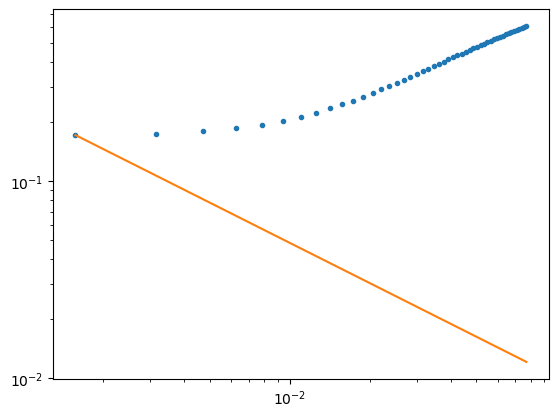

In [12]:
Delta = 0.42
powD = 1. - 4*Delta
plt.loglog(omega[M+1:M+50], np.abs(DRomega[M+1:M+50]),'.') 
fudfacD = np.abs(DRomega[M+1])/((omega[M+1])**powD)
plt.loglog(omega[M+1:M+50], fudfacD * (omega[M+1:M+50])**powD)

# See what the free boson real frequency retarded propagator looks like

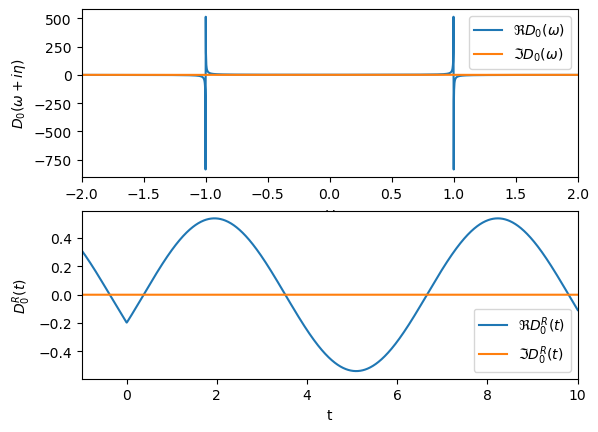

In [13]:
fig,ax = plt.subplots(2)

DR_free_omega = 1/(r - (omega+1j*eta)**2)
#DR_free_omega = 1/(r + 1j*eta - (omega)**2)
DR_free_t = (0.5/np.pi)*freq2time(DR_free_omega,M,dt)

ax[0].plot(omega,np.real(DR_free_omega), label = r'$\Re{D_0(\omega)}$')
ax[0].plot(omega,np.imag(DR_free_omega), label = r'$\Im{D_0(\omega)}$')
ax[0].set_xlabel(r'$\omega$')
ax[0].set_ylabel(r'$D_0(\omega+i\eta)$')
ax[0].set_xlim(-2,2)
ax[0].legend()

ax[1].plot(t,np.real(DR_free_t), label = r'$\Re D^R_0(t)$')
ax[1].plot(t,np.imag(DR_free_t), label = r'$\Im D^R_0(t)$')
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$D_0^R(t)$')
ax[1].set_xlim(-1,10)
ax[1].legend()
